In [10]:
import praw
import pandas as pd
import numpy as np
import networkx as nx
import numpy as np
import igraph as ig
import leidenalg
import pickle
import matplotlib.pyplot as plt
commentFrame = pd.read_pickle("comments.pkl")
with open("user_graph.pkl", "rb") as f:
    graph = pickle.load(f)

In [11]:

#variance = 1- (commentFrame["sentimentLabel"].var())
#print(f"variance: {variance}")
deg_assort = nx.degree_assortativity_coefficient(graph)
deg_assort = (deg_assort+1)/2
print('Degree assortivity:', deg_assort)
sentiments = [d['sentiment'] for _, d in graph.nodes(data=True) if "sentiment" in d]
homogenity = 1 - np.var(sentiments)
print(f"homogenity: {homogenity}")
assort = nx.attribute_assortativity_coefficient(graph, "sentiment")
assort = (assort+1)/2
print(f"sentiment assortivity: {assort}")


Degree assortivity: 0.4342650412270491
homogenity: 0.7844978458279479
sentiment assortivity: 0.4956898076917233


In [12]:
nodeList = list(graph.nodes())
edges = [(nodeList.index(u), nodeList.index(v)) for u, v in graph.edges()]

g = ig.Graph(edges = edges, directed = False)

if nx.get_edge_attributes(graph, "weight"):
    g.es["weight"] = [graph[u][v].get("weight", 1.0) for u, v in graph.edges()]
if nx.get_node_attributes(graph, "sentiment"):
    g.vs["sentiment"] = [graph.nodes[n].get("sentiment", 0) for n in graph.nodes()]


partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, seed = 7)

membership = partition.membership
print('communities: ', len(partition))
e_internal = 0
e_between = 0
for e in g.es:
    u, v = e.tuple
    weight = e["weight"] if "weight" in e.attributes() else 1.0
    if membership[u] == membership[v]:
        e_internal += 1
    else:
        e_between += 1
        
fraction = 1 - (e_between / (e_internal+e_between))
print(f"cross talk fraction: {fraction}")

print("Modularity:", partition.quality())

weights = commentFrame['upvotes'].clip(lower=0).fillna(0)
#weights = np.log1p(weights)
pos_weight = weights[commentFrame['sentimentLabel'] == 1].sum()
neg_weight = weights[commentFrame['sentimentLabel'] == -1].sum()
total_weight = pos_weight + neg_weight
if total_weight == 0:
    sentiment_skew = 0.5
else:
    pos_skew = pos_weight/total_weight
    neg_skew = neg_weight/total_weight
    sentiment_skew = max(pos_skew, neg_skew)
print(f'sentiment skew: {sentiment_skew}')
#SHOULD I KEEP SKEW HERE

communities:  32
cross talk fraction: 0.6574232081911262
Modularity: 0.566195077985766
sentiment skew: 0.7854411887469739


Text(0.5, 1.1, 'Echo Chamber Metrics Radar')

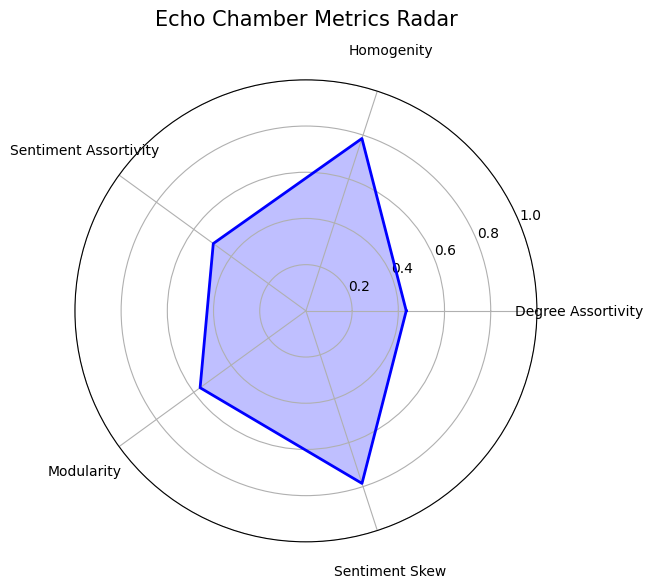

In [13]:
#spider graph
labels = ['Degree Assortivity', 'Homogenity', 'Sentiment Assortivity', 'Modularity', 'Sentiment Skew']
num_vars = len(labels)
values = [deg_assort, homogenity, assort, partition.quality(), sentiment_skew]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
values += values[:1]
labels += labels[:1]


fig, ax = plt.subplots(figsize = (6,6), subplot_kw= dict(polar = True))

ax.plot(angles, values, color='b', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='b', alpha = 0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1])
ax.set_ylim(0,1)

for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    label.set_y(label.get_position()[1] - 0.1)


ax.set_title('Echo Chamber Metrics Radar', size = 15, y = 1.1)

75


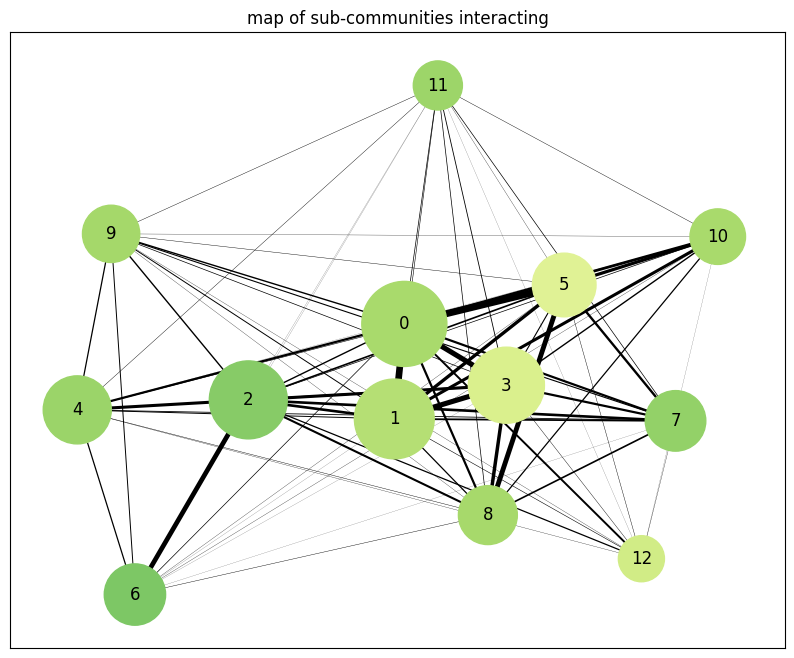

In [14]:


community_graph = nx.Graph()

node_to_comm = {}
edge_weights = {}
for index, nodes in enumerate(partition):
    for node in nodes:
        node_to_comm[node] = index
    sentiment = np.mean([g.vs[v]['sentiment'] for v in partition[index]])
    community_graph.add_node(index, size = len(nodes) * 50, sentiment = sentiment)

for e in g.es:
    u,v = e.tuple
    u_community = node_to_comm[u]
    v_community = node_to_comm[v]

    if u_community != v_community:
        edge = tuple(sorted((u_community, v_community)))  
        
        
        if community_graph.has_edge(*edge):
            community_graph[edge[0]][edge[1]]['weight'] += 1
        else:
            community_graph.add_edge(edge[0], edge[1], weight=1)




community_graph.add_edges_from(list(edge_weights.keys()))

isolates = list(nx.isolates(community_graph))
community_graph.remove_nodes_from(isolates)
node_sizes = [community_graph.nodes[n]['size'] + 50 for n in community_graph.nodes]
width = [data['weight'] * 0.1 for u,v,data in community_graph.edges(data = True)]
norm = plt.Normalize(vmin= -1, vmax = 1)
color_map = plt.cm.RdYlGn
node_colors = [color_map(norm(community_graph.nodes[v]['sentiment'])) for v in community_graph.nodes()]

#community_graph.es['weight'] = list(edge_weights.values())
pos = nx.spring_layout(community_graph, seed = 43, k=5)
plt.figure(figsize=(10,8))
plt.title('map of sub-communities interacting')
nx.draw_networkx(community_graph,
                  pos=pos,
                  node_size = node_sizes,
                  width = width,
                  node_color = node_colors
                  )
print(len(community_graph.edges))
#several micro communities but excluded for clarity
#this basically says does the graph split into any 'sub echo chambers'

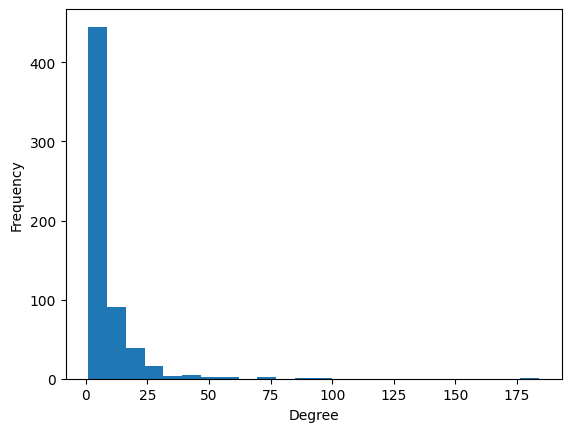

In [15]:
degrees = [graph.degree(n) for n in graph.nodes]
num = int(np.sqrt(graph.number_of_nodes()))
plt.ylabel("Frequency")
plt.xlabel("Degree")


plt.hist(degrees, bins = num)

plt.show()

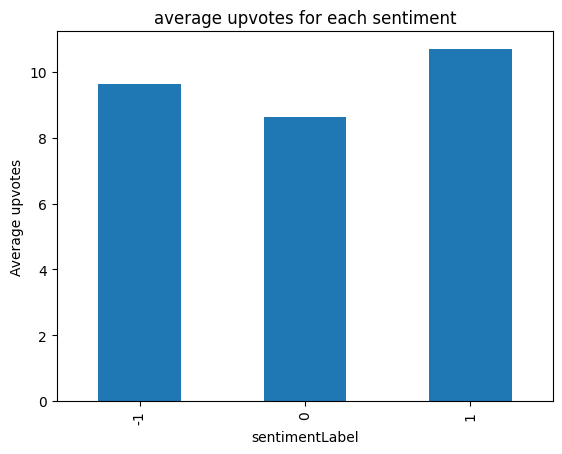

In [16]:

avg_upvotes = commentFrame.groupby('sentimentLabel')['upvotes'].mean()
avg_upvotes.plot(kind = 'bar')
plt.title('average upvotes for each sentiment')
plt.ylabel('Average upvotes')
plt.show()
#likely shows that even fan subreddits can still be rightfully critising stuff, like r/NintendoSwitch with legends ZA

0.5


<BarContainer object of 13 artists>

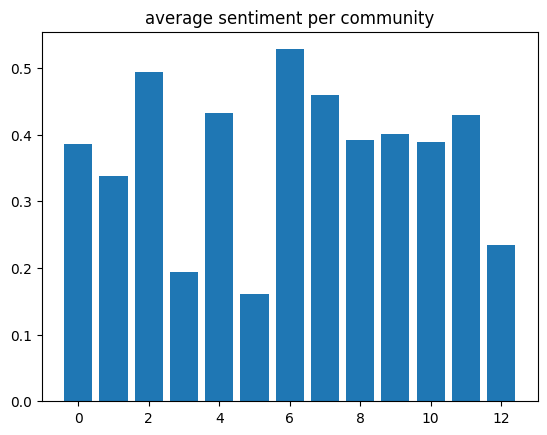

In [17]:
comms = [comms for comms in partition if len(comms) >> 4]
x = [index for index, _ in enumerate(comms)]
y = [np.mean([g.vs[v]['sentiment'] for v in comm]) for comm in comms]
print(sentiment)
#plt.ylim(-1,1)
plt.title('average sentiment per community')
plt.bar(x, y)